# ⚡️ Training a spiking network with Jax

## Requirements and housekeeping

In [5]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rockpool
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax
from rockpool.nn.combinators import Sequential

# - Typing
from typing import Callable, Dict, Tuple
import types

# - Numpy
import numpy as np

# - Pretty printing
try:
    from rich import print
except:
    pass

# T- QDM
from tqdm.autonotebook import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


## Signal generation from frozen noise task
We will use a single feed-forward layer of spiking neurons to convert a chosen pattern of random input spikes over time, into a pre-defined temporal signal with complex dynamics.

The network architecture is strictly feedforward, but the spiking neurons nevertheless contain temporal dynamics in their synaptic and membrane signals, with explicit time constants.

Some number of input channels `Nin` will contain independent Poisson spikes at some rate `spiking_prob/dt`. A single output channel should generate a chirp signal with increasing frequency, up to a maximum of `chirp_freq_factor`. You can play with these parameters below.

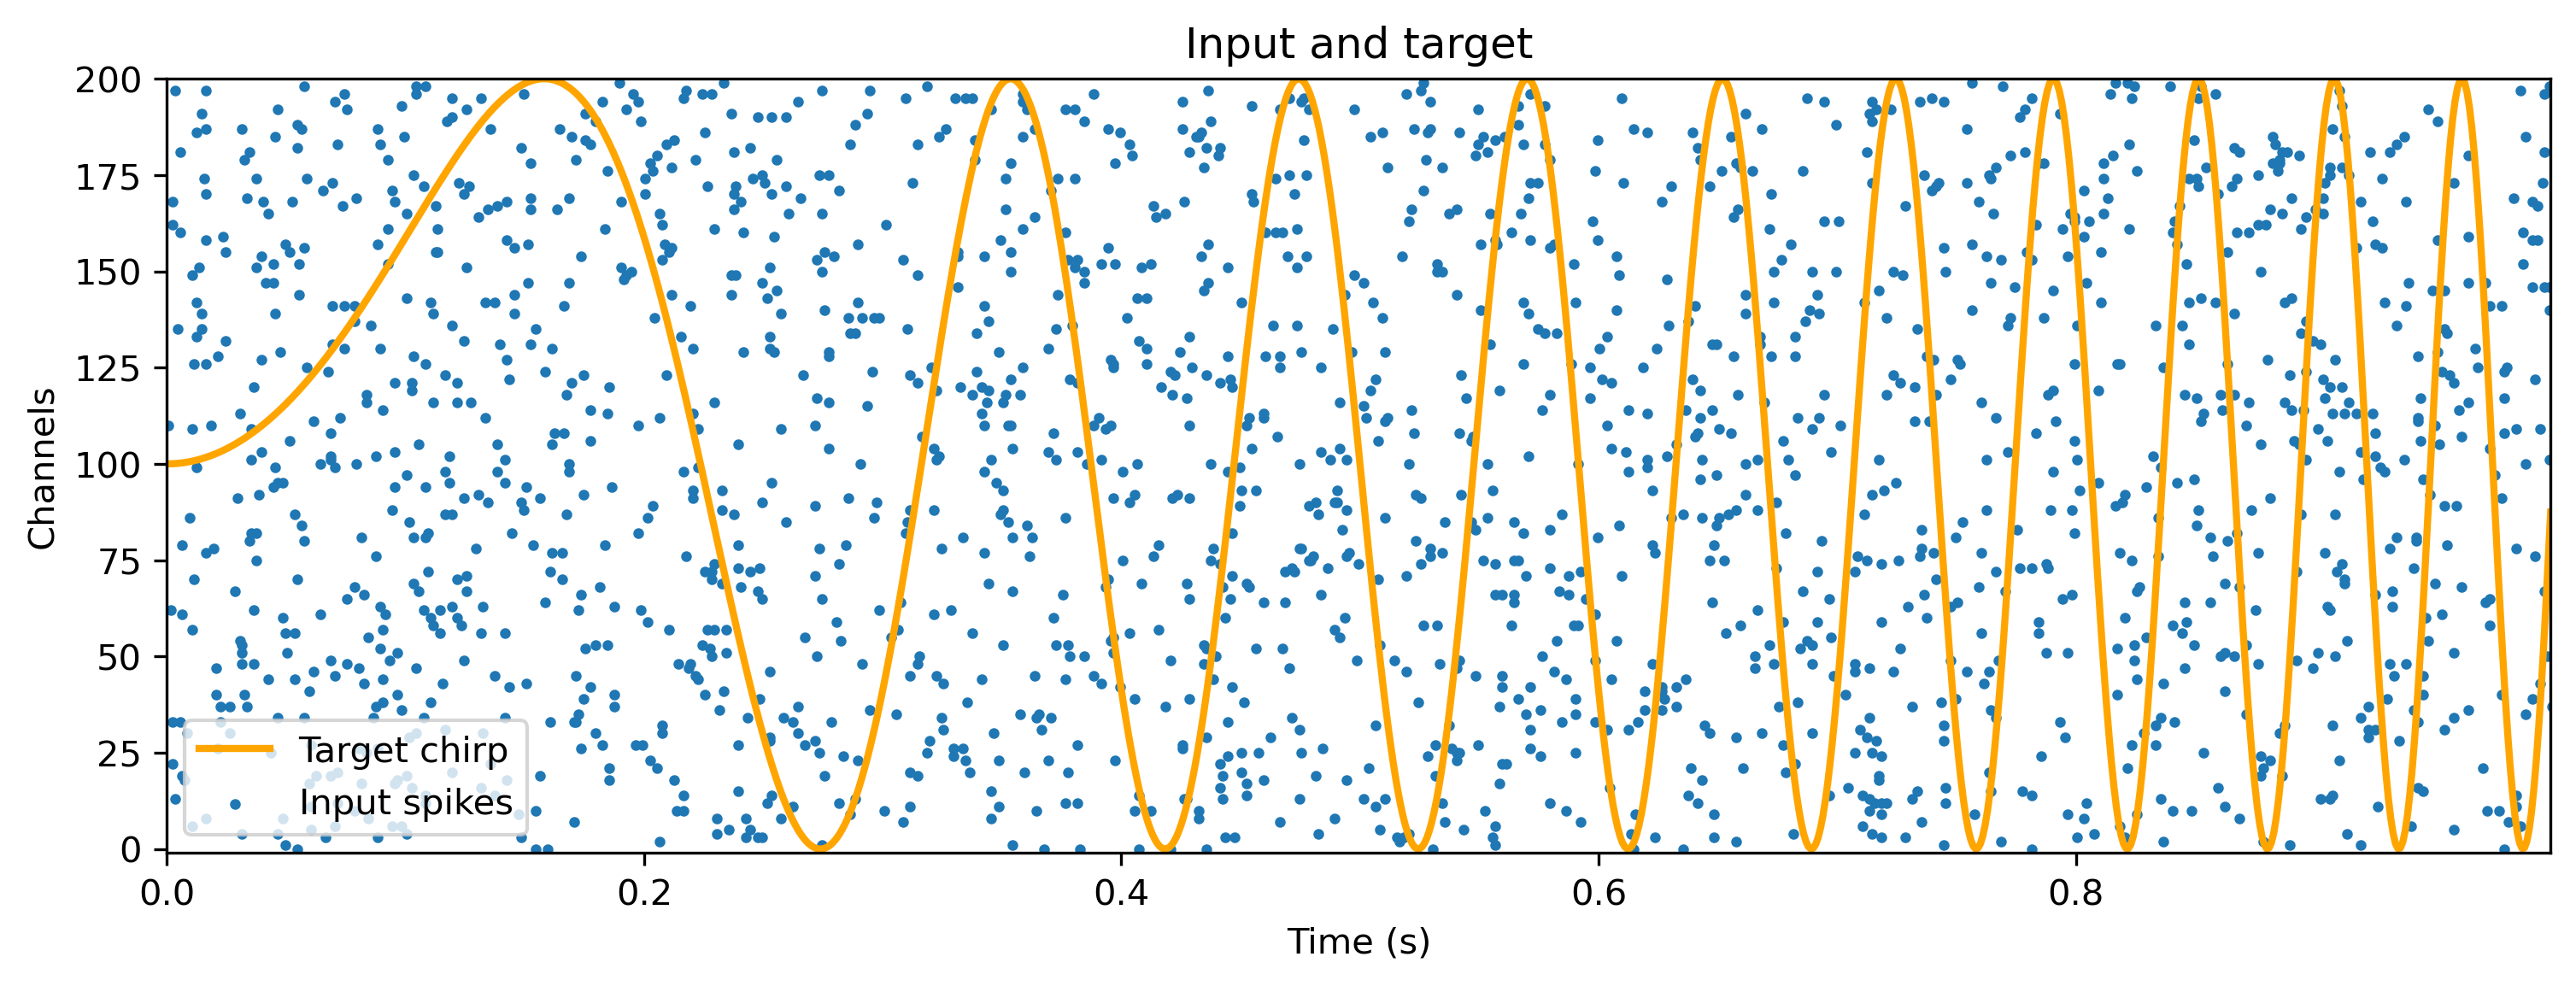

In [6]:
# - Define input and target
Nin = 200
dt = 1e-3
chirp_freq_factor = 10
dur_input = 1000e-3

# - Generate a time base
T = int(np.round(dur_input / dt))
timebase = np.linspace(0, (T-1) * dt, T)

# - Generate a chirp signal as a target
chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T
target_ts = TSContinuous(timebase, chirp, periodic = True, name = 'Target chirp')

# - Generate a Poisson frozen random spike train
spiking_prob = .01
input_sp_raster = np.random.rand(T, Nin) < spiking_prob
input_sp_ts = TSEvent.from_raster(input_sp_raster, name = 'Input spikes', periodic = True, dt = dt)

# - Plot the input and target signals
plt.figure()
input_sp_ts.plot(s = 4)
(target_ts * Nin/2 + Nin/2).plot(color="orange", lw=2)
plt.legend()
plt.title('Input and target');

## LIF neuron
The spiking neuron we will use is a leaky integrate-and-fire spiking neuron ("LIF" neuron). This neuron recevies input spike trains $S_{in}(t) = \sum_j\delta(t-t_j)$, which are integrated via weighted exponential synapses. Synaptic currents are then integrated into a neuron state ("membrane potential") $V_{mem}$.

The neuron obeys the dynamics
$$\tau_{mem}\cdot\dot{V}_{mem} + V_{mem} = {I}_{syn} + I_{bias} + \sigma\zeta(t)$$
$$\tau_{syn}\cdot\dot{I}_{syn} + I_{syn} = 0$$
$$I_{syn} += W_{in} \cdot S_{in}(t)$$

Where $\tau_{mem}$ and $\tau_{syn}$ are membrane and synaptic time constants; $I_{bias}$ is a constant bias current for each neuron; $\sigma\zeta(t)$ is a white noise process with std. dev. $\sigma$.

Output spikes are generated when $V_{mem}$ crosses the firing threshold $V_{th} = 0$. This process generates a spike train $S(t)$ as a series of delta functions, and causes a subtractive reset of $V_{mem}$:

$$V_{mem} > V_{th} \rightarrow S(t) = H(V_{mem}(t)), V_{mem} = V_{mem} - 1$$

The analog output signal is generated using a surrogate
$$U(t) = \tanh(x + 1) / 2 + 0.5$$

The output of the network $o(t)$ is therefore given by
$$o(t) = W_{out} \cdot S(t)$$

## Build a network
The network architecture is a single feedforward layer, with weighted spiking inputs and outputs. Spiking is generated via a function that provides a surrogate gradient in the backwards pass. This permits propagation of an error gradient through the layer, making gradient-descent training possible.

You can play with the network size `N` below, as well as the initial membrane and synapse time constants `tau_mem` and `tau_syn`, and the initial bias `bias`. All these parameters will be optimised during training.

In [16]:
# - Network size
N = 50
Nout = 1

In [33]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N), has_bias = False, spiking_input = True),
        LIFJax(N, dt = dt),
    LinearJax((N, Nout), has_bias = False),
).timed(dt = dt)

modFFwd

TimedModuleWrapper  with shape (200, 1) {
    JaxSequential '_module' with shape (200, 1) {
        LinearJax '0_LinearJax' with shape (200, 50)
        LIFJax '1_LIFJax' with shape (50, 50)
        LinearJax '2_LinearJax' with shape (50, 1)
    }
} with JaxSequential '_module' as module

## Simulate initial state of network
If we simulate the untrained network with our random input spikes, we don't expect anything sensible to come out. Let's do this, and take a look at how the network behaves.

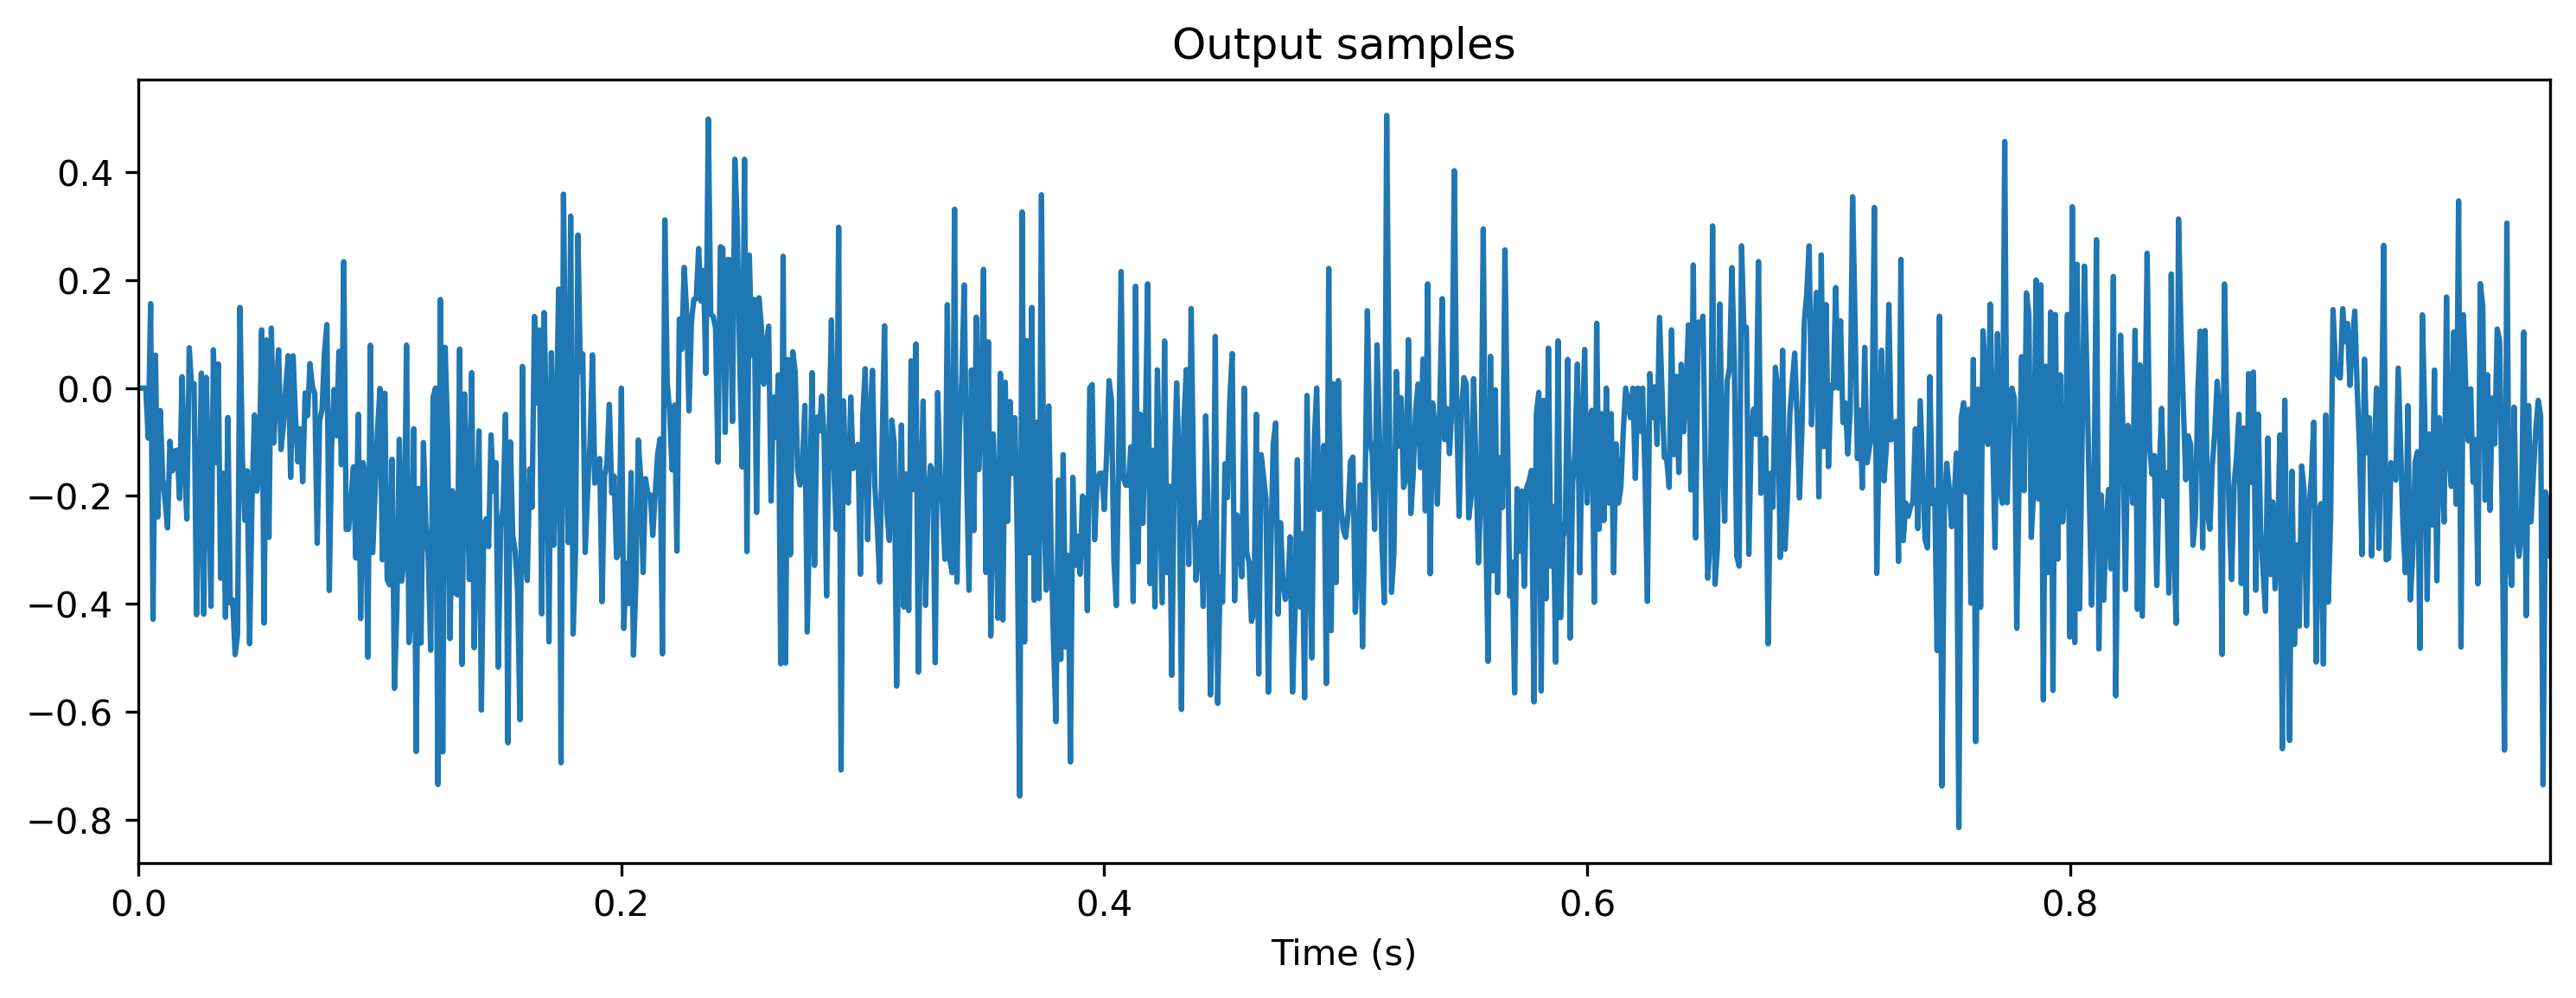

In [34]:
# - Randomise the network state
modFFwd.reset_state()

# - Evolve with the frozen noise spiking input
tsOutput, new_state, record_dict = modFFwd(input_sp_ts, record = True)

# - Plot the analog output
plt.figure()
tsOutput.plot();

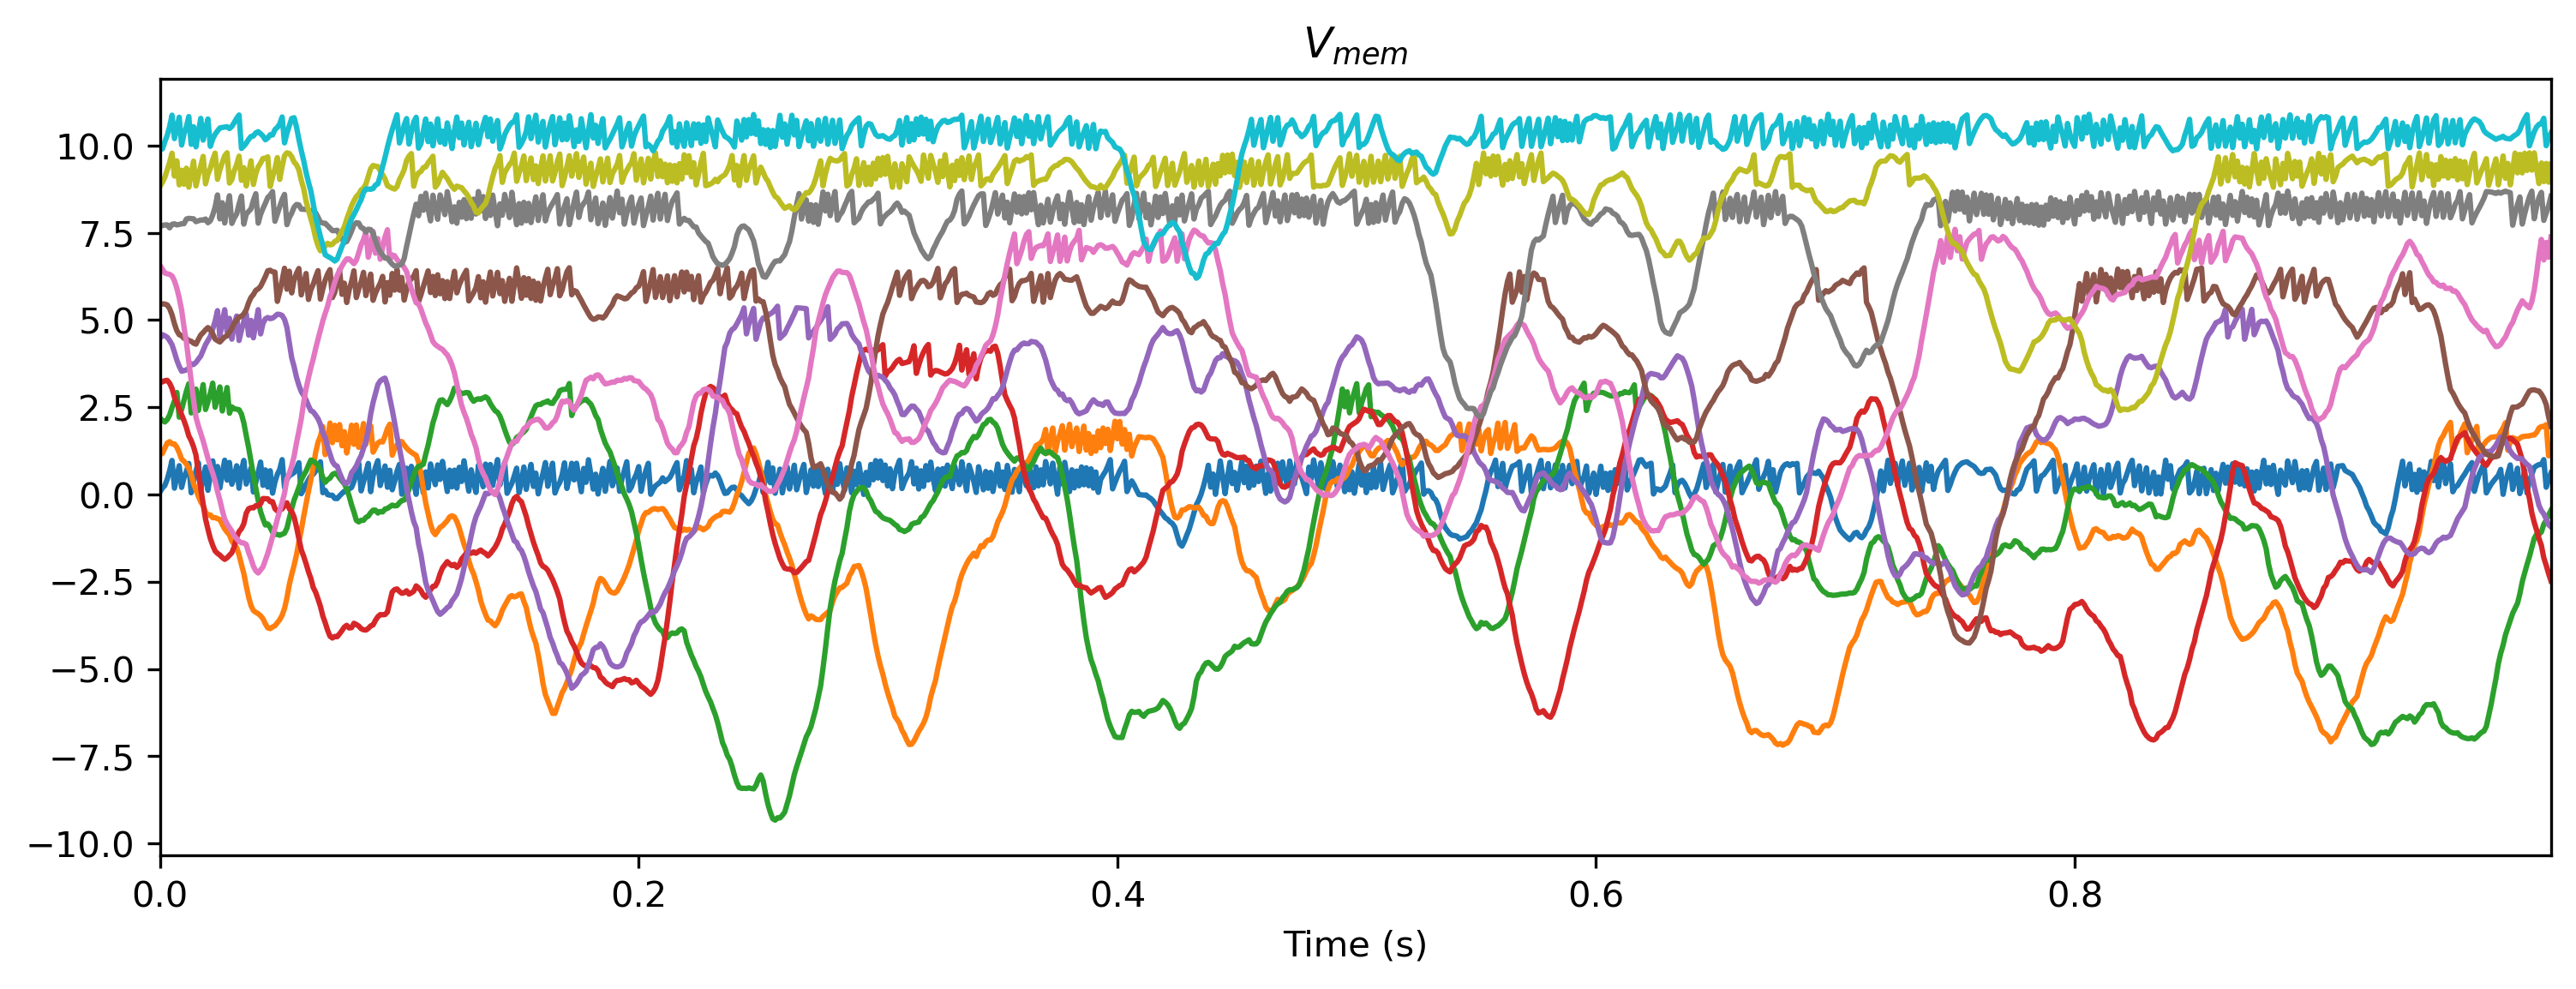

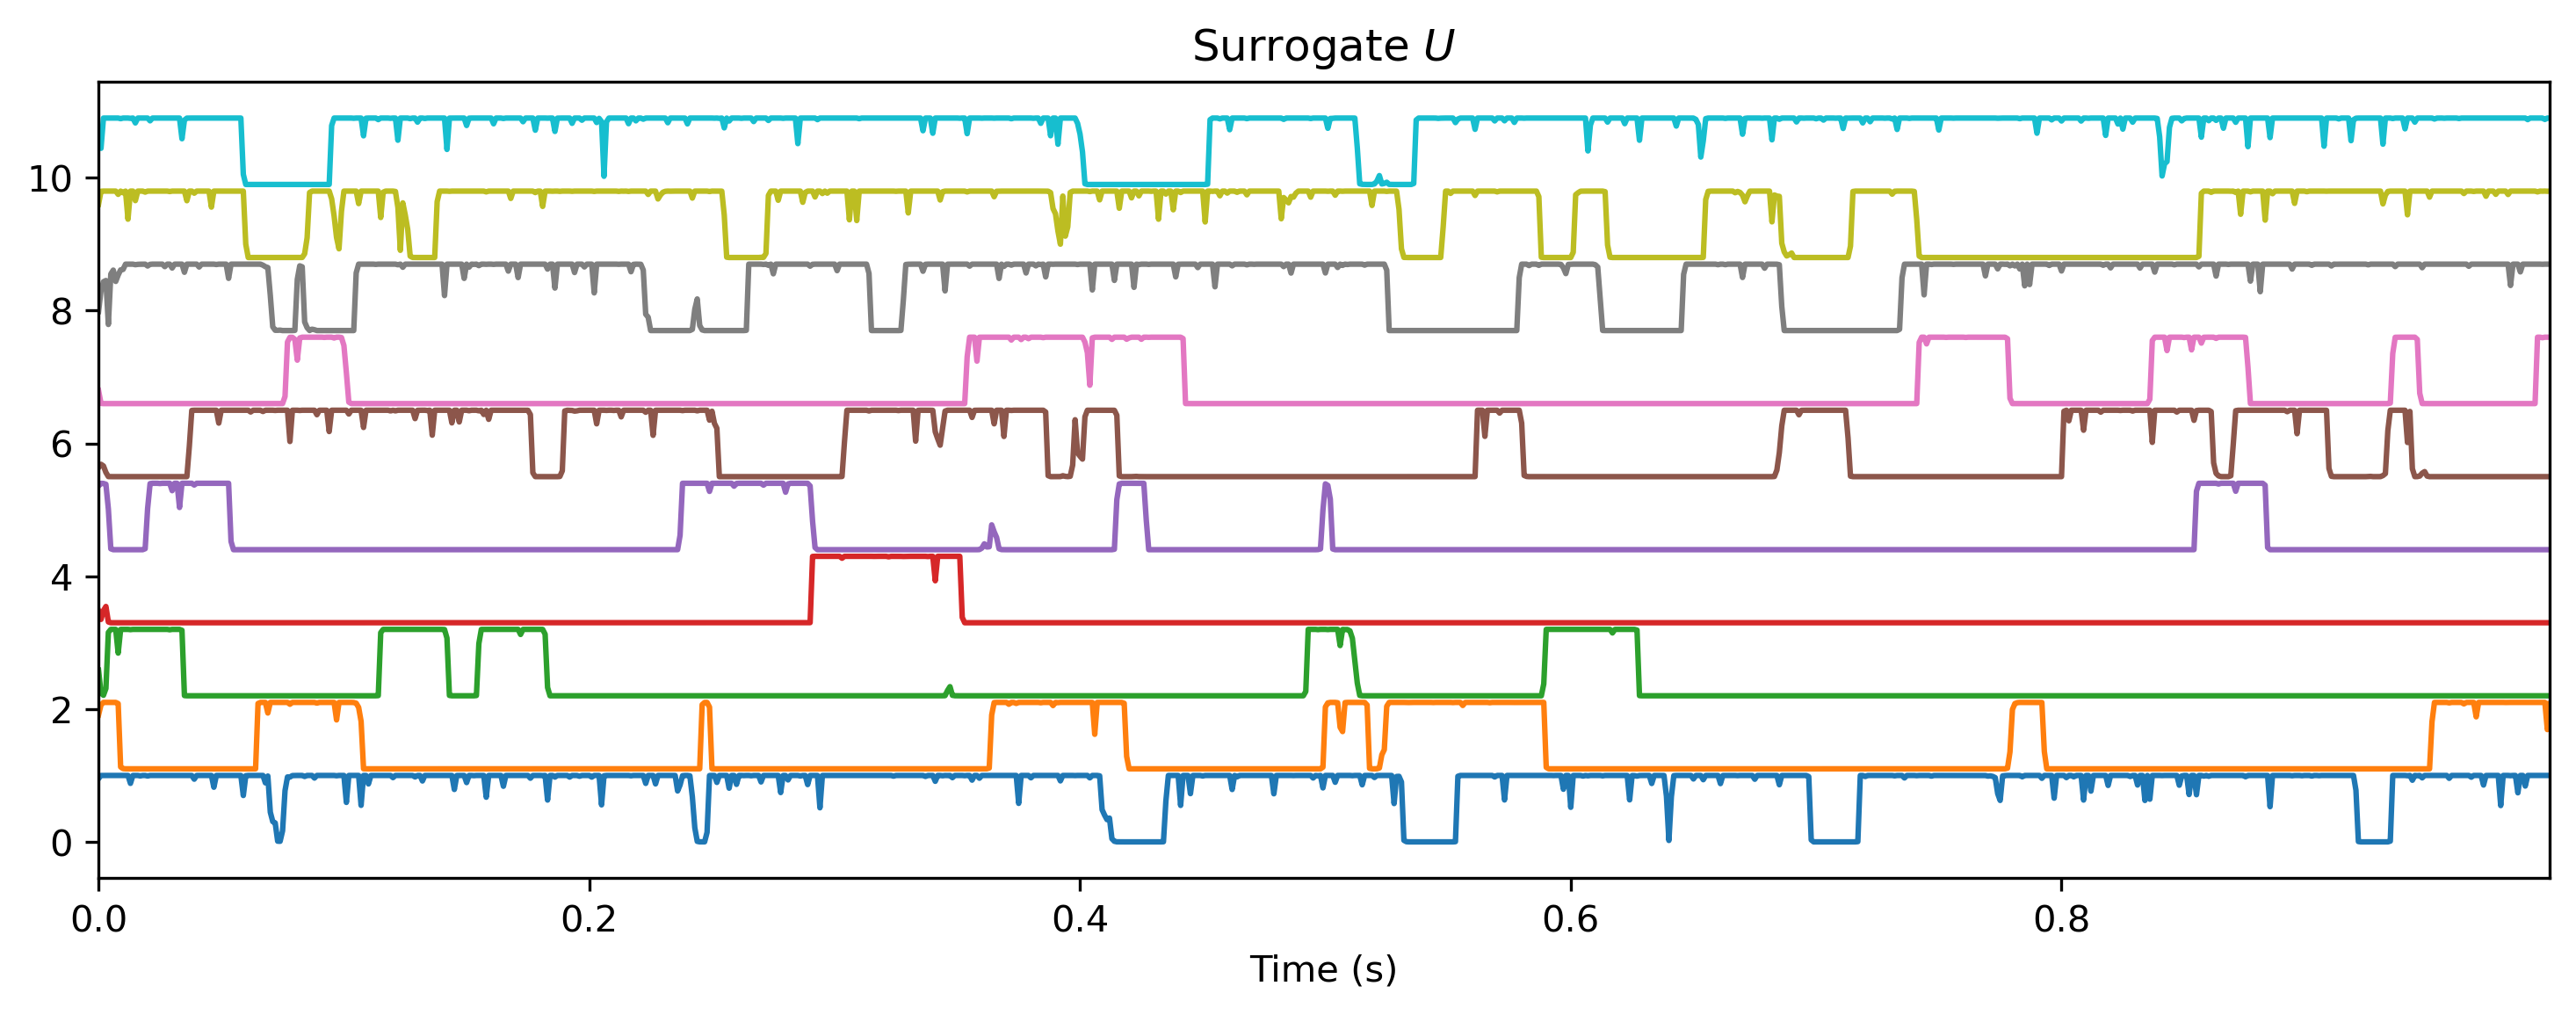

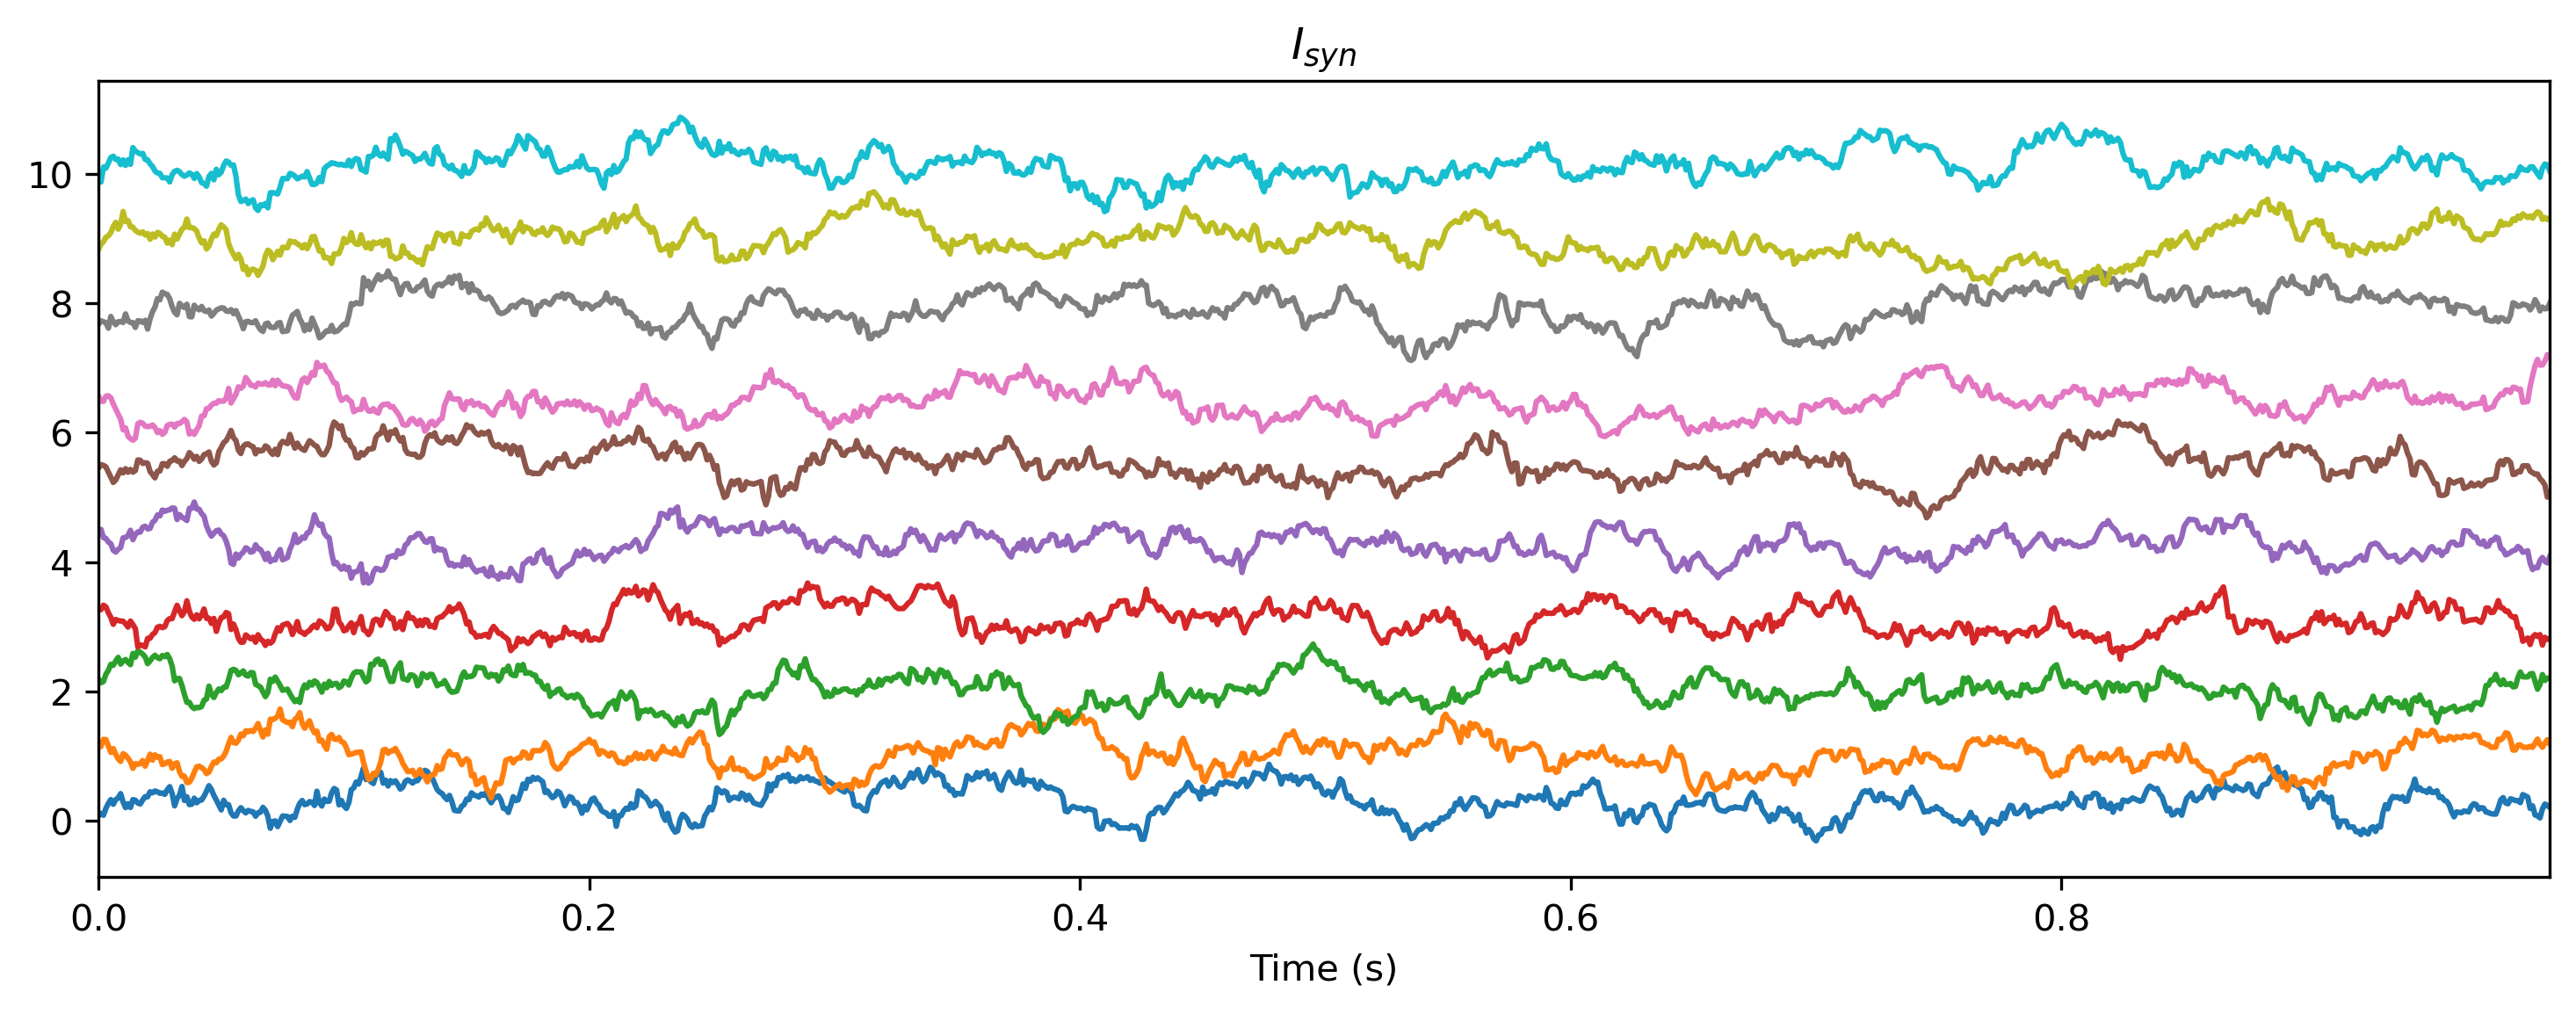

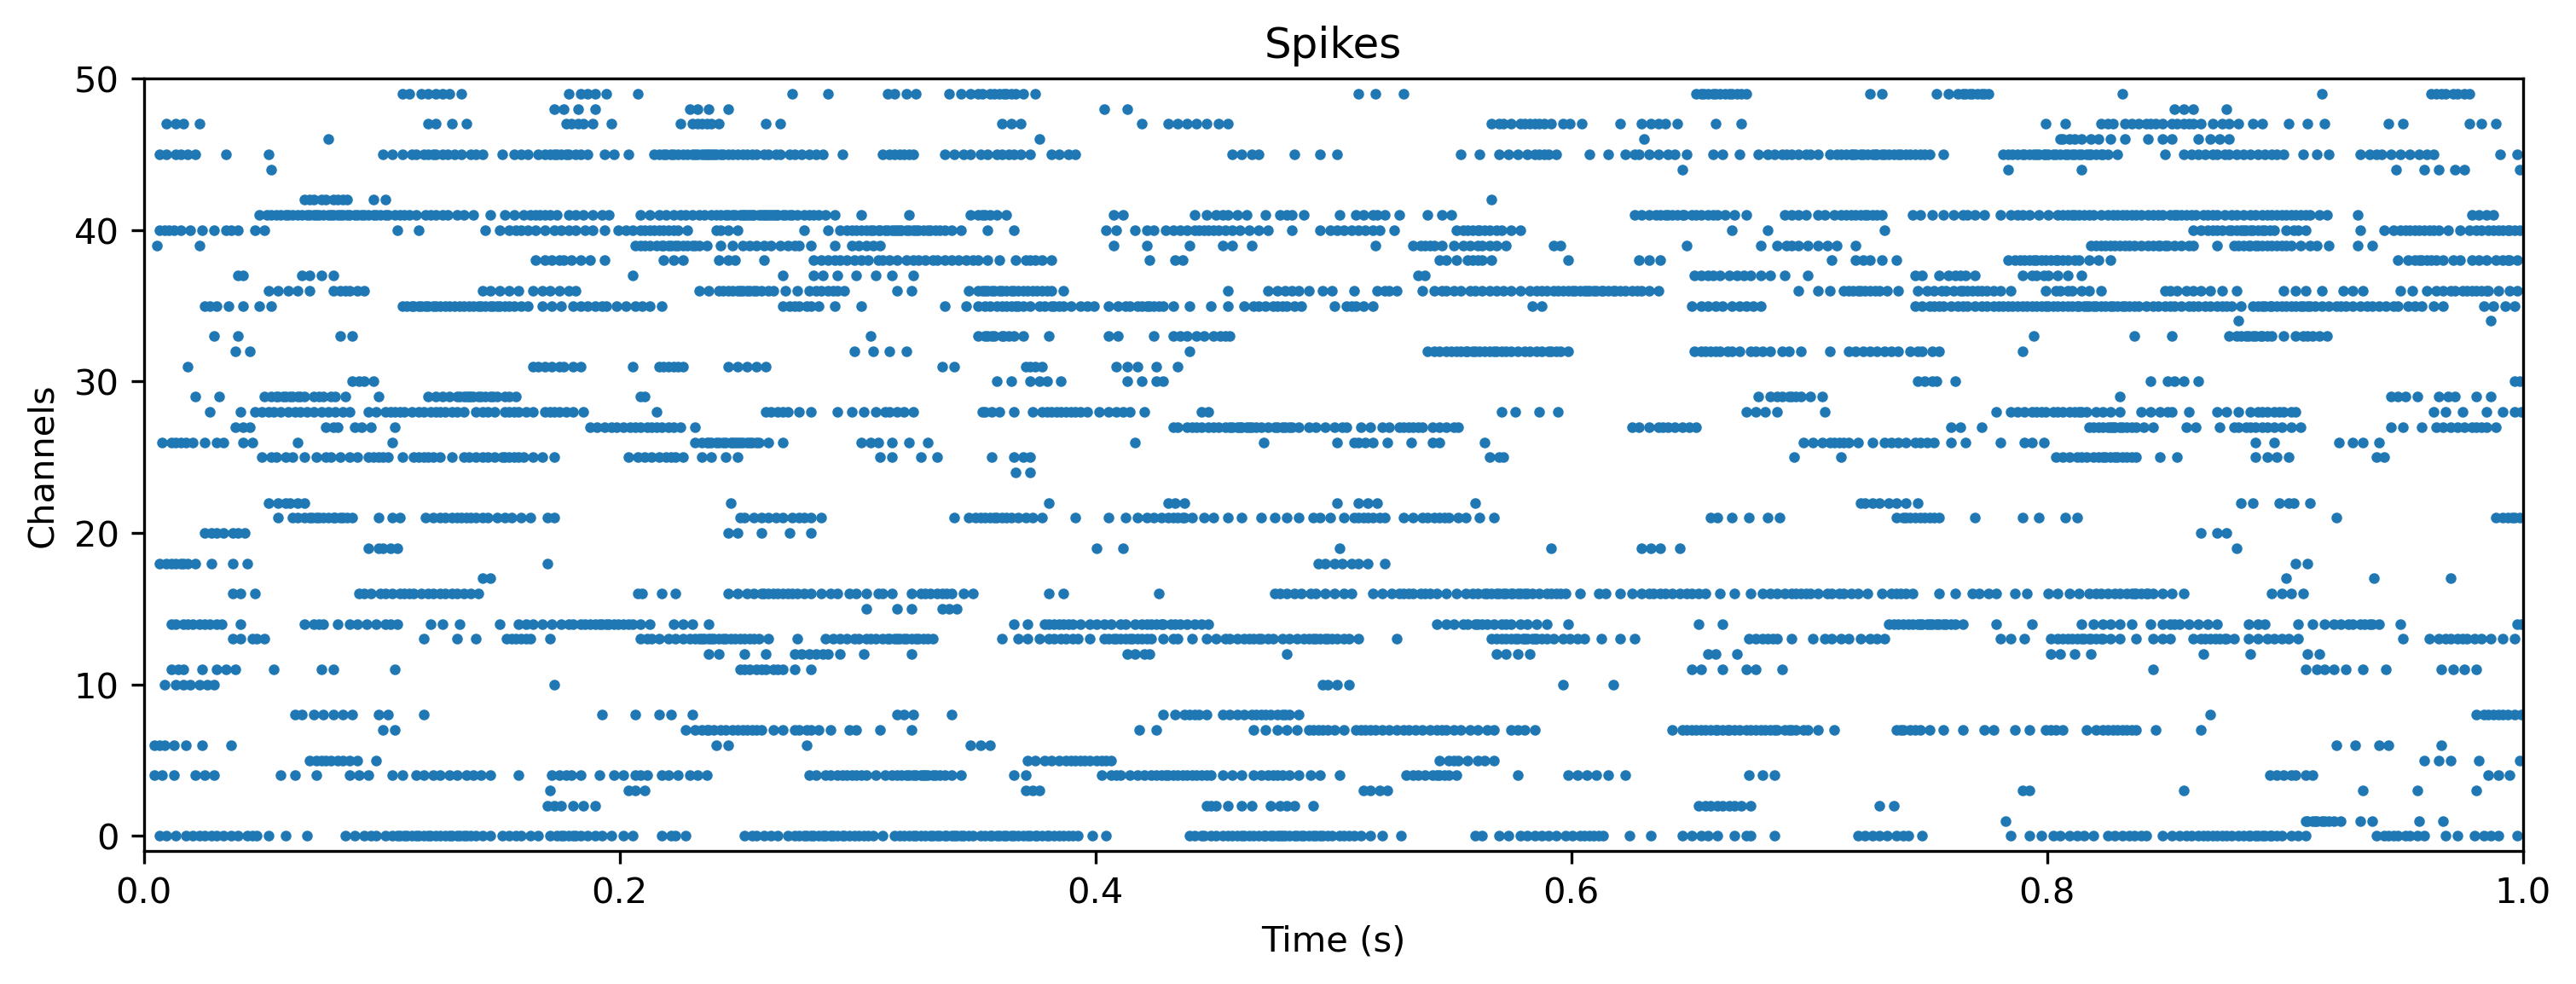

In [35]:
# - Make a function that converts ``record_dict``
def plot_record_dict(rd):
    Vmem_ts = rd['1_LIFJax']['vmem']
    U_ts = rd['1_LIFJax']['U']
    Isyn_ts = rd['1_LIFJax']['isyn']
    spikes_ts = rd['1_LIFJax']['spikes']

    # - Plot the internal activity of selected neurons
    plt.figure()
    Vmem_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    U_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    Isyn_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    spikes_ts.plot(s=4);
    
plot_record_dict(record_dict)

## Training the network

In [36]:
import rockpool.training.jax_loss as l
import jax.numpy as jnp

# - Define a loss function
def loss_mse(params, net, input, target):
    # - Reset the network state
    net = net.reset_state()
    
    # - Apply the parameters
    net = net.set_attributes(params)
    
    # - Evolve the network
    output, _, states = net(input, record = True)

    # - Return the loss
    return l.mse(output, target)

Below we define a training loop that uses a gradient-descent optimisation algorithm ("Adam", provided by Jax) to iteratively optimise the network parameters. We keep track of the loss value for each iteration for later visualisation.

In [44]:
# - Scale down input weights
params = modFFwd.parameters('weights')
params['_module']['0_LinearJax']['weight'] = params['_module']['0_LinearJax']['weight'] / 1e4
params['_module']['0_LinearJax']['weight'] = params['_module']['0_LinearJax']['weight'] / 1e4
modFFwd = modFFwd.set_attributes(params)

In [46]:
import jax
jax.jit(jax.grad(loss_mse))(modFFwd.module.parameters(), modFFwd.module, np.array(1.), 0.)

{'0_LinearJax': {'weight': DeviceArray([[           nan,            nan,            nan, ...,
                           nan,            nan,            nan],
               [           nan,            nan,            nan, ...,
                           nan,            nan,            nan],
               [           nan,            nan,            nan, ...,
                           nan,            nan,            nan],
               ...,
               [-1.1868032e+21,  9.0776018e+20, -9.9381686e+20, ...,
                 0.0000000e+00,  0.0000000e+00,  1.6684666e+21],
               [-9.2004121e+20,  9.7037351e+20, -5.3220930e+20, ...,
                 0.0000000e+00,  0.0000000e+00,  1.2495869e+21],
               [-6.5542110e+20,  7.3091656e+20, -1.7171735e+20, ...,
                 0.0000000e+00,  0.0000000e+00,  6.4531270e+20]],            dtype=float32)},
 '1_LIFJax': {'bias': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, na

In [ ]:
# - Useful imports
from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.experimental.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-4)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(modFFwd.module.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 20000

# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, modFFwd.module, input_sp_raster, chirp)

    # - Update the optimiser
    opt_state = update_fun(next(i_trial), grads, opt_state)

    # - Keep track of the loss
    loss_t.append(loss_val)

In [ ]:
# - Plot the loss 
plt.figure()
plt.plot(loss_t)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training iteration');
plt.title('Training progress');

## Plot the ouput of the trained network

In [ ]:
# - Simulate with trained parameters
modFFwd._module = modFFwd._module.set_attributes(get_params(opt_state))
modFFwd._module = modFFwd._module.reset_state()
output_ts, _, record_dict = modFFwd(input_sp_ts)

# - Compare the output to the target
output_ts.plot()
target_ts.plot(output_ts.times, lw=3)
plt.legend();
plt.title('Output vs target')

# - Plot the internal state of selected neurons
plot_record_dict(record_dict)

## Plot the network parameters
Let's see how much the network parameters changed. Since the initial parameter set was random, we'll plot the difference between the trained and initial parameters $\theta^* - \theta$.

In [ ]:
modIn = modFFwd.module.modules()['0_LinearJax']
modLIF = modFFwd.module.modules()['1_LIFJax']
modOut = modFFwd.module.modules()['2_LinearJax']

In [ ]:
# - Plot the change in input weights
plt.figure()
plt.imshow(modIn.weight - params0['0_LinearJax']['weight'], aspect = "auto");
plt.title('Input weight change $w^*_{in}-w_{in}$')
plt.set_cmap('PuOr')

# - Plot the change in output weights
plt.figure()
plt.stem(modOut.weight - params0['2_LinearJax']['weight'])
plt.title('Output weight change $w^*_{out}-w_{out}$')

# - Plot the distribution of final time constants
plt.figure()
plt.hist(modLIF.tau_mem * 1e3, 20)
plt.stem([tau_mem * 1e3], [50])
plt.xlabel('$\\tau_{mem}$ (ms)')
plt.title('Histogram of membrane time constants $\\tau_{mem}$')

plt.figure()
plt.hist(modLIF.tau_syn * 1e3, 20)
plt.stem([tau_syn * 1e3], [50])
plt.xlabel('$\\tau_{syn}$ (ms)')
plt.title('Histogram of synaptic time constants $\\tau_{syn}$');

# - Plot the distribution of final biases
plt.figure()
plt.hist(modLIF.bias, 20)
plt.stem([bias], [50])
plt.xlabel('Bias value $I_{bias}$')
plt.title('Histogram of neuron biases $I_{bias}$');

The power of automatic differentiation is that almost for free, we get to optimise not just the weights, but all time constants and biases simultaneously. And we didn't have to compute the gradients by hand!

As a sanity check, let's see how the trained network responds if we give it a different random noise input.

In [ ]:
spiking_prob = .01
sp_rand_ts = np.random.rand(T, Nin) < spiking_prob
spikes = np.argwhere(sp_rand_ts)
random_sp_ts = TSEvent.from_raster(sp_rand_ts, dt = dt,
                                   name = 'Input spikes', periodic = True,
                                  )

In [ ]:
# - Simulate with trained parameters
modFFwd._module = modFFwd._module.set_attributes(get_params(opt_state))
modFFwd._module = modFFwd._module.reset_state()
output_ts, _, record_dict = modFFwd(random_sp_ts)

# - Compare the output to the target
output_ts.plot()
target_ts.plot(output_ts.times, lw=3)
plt.legend();
plt.title('Output vs target')

# - Plot the internal state of selected neurons
plot_record_dict(record_dict)

As expected, the network doesn't do anything sensible with data it has never seen.

## Summary
This approach can be used identically to train recurrent spiking networks, as well as multi-layer (i.e. deep) networks.